# Infer ***lipid droplet*** - part 9️⃣

--------------
OBJECTIVE: ✅ Infer sub-cellular component ***lipid droplet***  in order to understand interactome 



Dependencies:
The  ***lipid droplet***  inference rely on the cytoplasm mask.



## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from typing import Optional
import numpy as np


from aicssegmentation.core.pre_processing_utils import image_smoothing_gaussian_slice_by_slice
from aicssegmentation.core.utils import hole_filling
from skimage.measure import label

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc.core.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)

from infer_subc.core.img import *

from infer_subc.organelles import get_cellmask, get_nuclei, get_cytoplasm

%load_ext autoreload
%autoreload 2


In [2]:
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )              


## SETUP

In [3]:
# this will be the example image for testing the pipeline below
test_img_n = TEST_IMG_N

# build the datapath
# all the imaging data goes here.
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
in_data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

# save output ".tiff" files here
out_data_path = data_root_path / "out"

if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [4]:
img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## GET CYTOSOL MASK

> note: don't actually need it here, but getting for testing and visualization purposes.


In [5]:

###################
# SOMA, NUCLEI, CYTOSOL, NUCLEUS
###################
nuclei_obj =  get_nuclei(img_data,meta_dict, out_data_path)
soma_obj = get_cellmask(img_data, nuclei_obj, meta_dict, out_data_path)
cytoplasm_mask = get_cytoplasm(nuclei_obj , soma_obj , meta_dict, out_data_path)



>>>>>>>>>>>> tifffile.imread  (dtype=uint8in (0.01) sec
loaded  inferred 3D `nuclei`  from /Users/ahenrie/Projects/Imaging/data/out 
>>>>>>>>>>>> tifffile.imread  (dtype=int32in (0.03) sec
loaded  inferred 3D `cellmask`  from /Users/ahenrie/Projects/Imaging/data/out 
>>>>>>>>>>>> tifffile.imread  (dtype=uint8in (0.01) sec
loaded  inferred 3D `cytoplasm`  from /Users/ahenrie/Projects/Imaging/data/out 


---------------------

## infer ***lipid droplet*** 

## summary of steps 

INPUT
- ch 7
- cytoplasm mask


PRE-PROCESSING
- rescale 
-  median, window 2
-  
CORE-PROCESSING
   - "robust background" 2 STD

POST-PROCESSING
  - n/a

OUTPUT
- object ***lipid droplet***




NOTE:  consider using [Fibrillarin](https://www.allencell.org/cell-observations/category/fibrillarin) (nucleous marker) workflow from AllenCell.  playground_spotty.ipynb  or maybe [centrin](https://www.allencell.org/cell-observations/category/centrin)


Not a good thing to follow from  the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.


## INPUT prototype

In [6]:
###################
# INPUT
###################
# raw_LD   = img_2D[LD_CH].copy()
raw_LD = select_channel_from_raw(img_data, LD_CH)


## PRE-PROCESSING prototype

In [7]:
###################
# PRE_PROCESSING
###################
median_sz = 2
gauss_sig = 1.34

struct_img =  scale_and_smooth(raw_LD,
                                                    median_sz = median_sz, 
                                                    gauss_sig = gauss_sig)


## CORE PROCESSING prototype

In [8]:

###################
# CORE_PROCESSING
###################

threshold_factor = 0.99 #from cellProfiler
thresh_min = .5
thresh_max = 1.
otsu_thresholded = apply_threshold(struct_img, method= "otsu", thresh_factor=threshold_factor, thresh_min=thresh_min, thresh_max=thresh_max)


## POST-PROCESSING prototype

In [9]:

###################
# POST_PROCESSING
###################
# # wrapper to remoce_small_objects
max_hole_w = 2.5
small_obj_w = 4
struct_obj = fill_and_filter_linear_size(otsu_thresholded, hole_min=0, hole_max=max_hole_w, min_size= small_obj_w)


LD_object = struct_obj
LD_labels = label( LD_object   )


#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [10]:

viewer = napari.view_image(
    LD_object,
)



In [11]:

viewer.scale_bar.visible = True
viewer.add_image(
    struct_img,
)

viewer.add_labels(
    LD_labels,
)

<Labels layer 'LD_labels' at 0x16393fdc0>

In [12]:
viewer.add_image(
    LD_object,
)



<Image layer 'LD_object [1]' at 0x1671ce310>

## DEFINE `infer_LD_body` function

Based on the _prototyping_ above define the function to infer the lipid boty.  


In [13]:
##########################
#  infer_LD
##########################
def _infer_LD(
                            in_img: np.ndarray,
                            median_sz: int,
                            gauss_sig: float,
                            method: str,
                            thresh_factor: float,
                            thresh_min: float,
                            thresh_max: float,
                            max_hole_w: int,
                            small_obj_w: int,
                        ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    method: 
        method for applying threshold.  "otsu"  or "li", "triangle", "median", "ave", "sauvola","multi_otsu","muiltiotsu"
    thresh_factor:
        scaling value for threshold
    thresh_min:
        absolute minumum for threshold
    thresh_max:
        absolute maximum for threshold
    max_hole_w: 
        hole filling cutoff for lipid post-processing
    small_obj_w: 
        minimu object size cutoff for lipid post-processing
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    LD_ch = LD_CH
    ###################
    # EXTRACT
    ###################    
    lipid = select_channel_from_raw(in_img, LD_ch)
    ###################
    # PRE_PROCESSING
    ###################                         
    lipid =  scale_and_smooth(lipid,
                                                    median_sz = median_sz, 
                                                    gauss_sig = gauss_sig)


    ###################
    # CORE_PROCESSING
    ###################
    bw = apply_threshold(lipid, 
                                            method= method, 
                                            thresh_factor=thresh_factor, 
                                            thresh_min=thresh_min, 
                                            thresh_max=thresh_max)


    ###################
    # POST_PROCESSING
    ###################
    # min_hole_w = 0
    struct_obj = fill_and_filter_linear_size(bw, hole_min=0, hole_max=max_hole_w, min_size= small_obj_w)

    return label_uint16(struct_obj)



In [14]:


##########################
#  fixed_infer_LD
##########################
def _fixed_infer_LD(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels

    Returns
    -------------
    LD_body_object
        mask defined extent of liipid body

    """

    median_sz = 2   
    gauss_sig = 1.34
    method = "otsu"
    threshold_factor = 0.99 #from cellProfiler
    thresh_min = .5
    thresh_max = 1.
    max_hole_w = 2.5
    small_obj_w = 4

    return _infer_LD(
        in_img,  median_sz, gauss_sig, method, threshold_factor, thresh_min, thresh_max, max_hole_w, small_obj_w
    )


# TEST  `infer_LD_body` function

In [15]:

_LD_obj =  _fixed_infer_LD(img_data) 

In [16]:
from infer_subc.organelles import fixed_infer_LD

LD_obj =  fixed_infer_LD(img_data) 

## Visualize  2


In [17]:

viewer.add_image(
    _LD_obj,
)

viewer.add_image(
    LD_obj,
)
viewer.add_labels(
    label(LD_obj),
)

<Labels layer 'Labels' at 0x1677915b0>

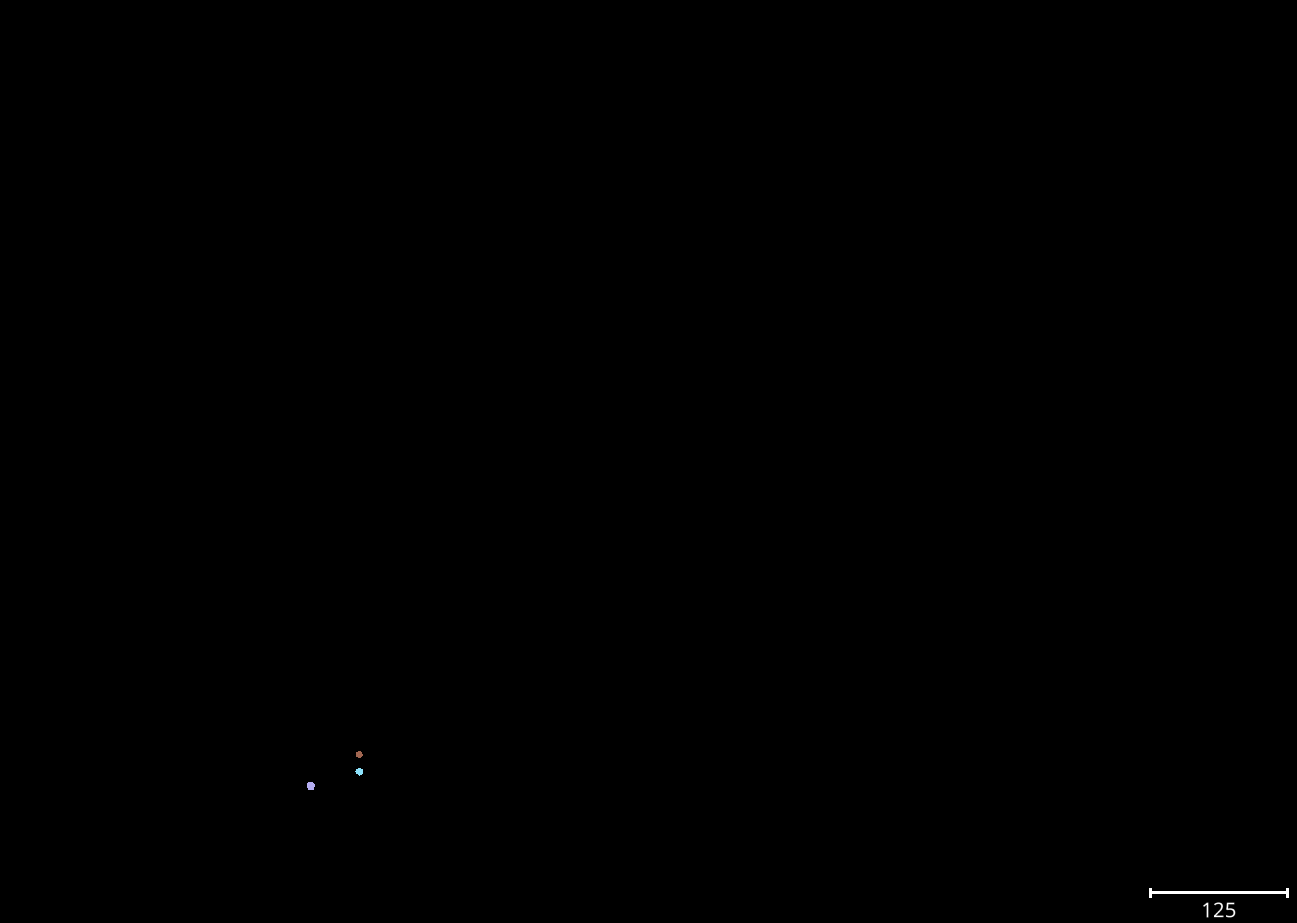

In [19]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)

In [20]:
viewer.close()

-------------
## SUMMARY

The above details how the endoplasmic lipid droplet is inferred.  

###  THATS IT!
